## 1. OBJECTIVE

According to a WHO assessment of the burden of disease due to air pollution, more than 2 million premature deaths each year can be attributed to the effects of urban outdoor air pollution and indoor air pollution (caused by the burning of solid fuels). The evidence on airborne particulate matter (PM) and its public health impact is consistent in showing adverse health effects at exposures that are currently experienced by urban populations in both developed and developing countries. Shanghai, the commercial capital city of People's Republic of China, is no exception in exceeding the healthy levels of pollution due to the impact of urbanization, motorization, and rapid population growth. In this report, we would like to use several years of meteorological and pollution data to predict the concentrations of PM2.5 (ug/m3).

## 2. DATA SET
Data Set Information:

The time period is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA. 



Attribute Information:

- No: row number 
- year: year of data in this row 
- month: month of data in this row 
- day: day of data in this row 
- hour: hour of data in this row 
- season: season of data in this row 
- PM: PM2.5 concentration (ug/m^3) 
- DEWP: Dew Point (Celsius Degree) 
- TEMP: Temperature (Celsius Degree) 
- HUMI: Humidity (%) 
- PRES: Pressure (hPa) 
- cbwd: Combined wind direction 
- Iws: Cumulated wind speed (m/s) 
- precipitation: hourly precipitation (mm) 
- Iprec: Cumulated precipitation (mm)

## 3. ANALYSIS

#### 3.1 Pre-processing

In [143]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import statsmodels.graphics.api as smg
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelcolor'] = '.4'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.minor.visible']= True
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['ytick.right'] = True

In [144]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [145]:
file = 'ShanghaiPM20100101_20151231 - Copy.csv'
pm = pd.read_csv(file,na_values='NA')
pm.columns

Index([u'No', u'year', u'month', u'day', u'hour', u'season', u'PM_Jingan',
       u'PM_US Post', u'PM_Xuhui', u'DEWP', u'HUMI', u'PRES', u'TEMP', u'cbwd',
       u'Iws', u'precipitation', u'Iprec'],
      dtype='object')

In [146]:
pm.shape

(52584, 17)

In [147]:
pm.dtypes

No                 int64
year               int64
month              int64
day                int64
hour               int64
season             int64
PM_Jingan        float64
PM_US Post       float64
PM_Xuhui         float64
DEWP             float64
HUMI             float64
PRES             float64
TEMP             float64
cbwd              object
Iws              float64
precipitation    float64
Iprec            float64
dtype: object

In [148]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
No               52584 non-null int64
year             52584 non-null int64
month            52584 non-null int64
day              52584 non-null int64
hour             52584 non-null int64
season           52584 non-null int64
PM_Jingan        24700 non-null float64
PM_US Post       34039 non-null float64
PM_Xuhui         25189 non-null float64
DEWP             52571 non-null float64
HUMI             52571 non-null float64
PRES             52556 non-null float64
TEMP             52571 non-null float64
cbwd             52572 non-null object
Iws              52572 non-null float64
precipitation    48575 non-null float64
Iprec            48575 non-null float64
dtypes: float64(10), int64(6), object(1)
memory usage: 6.8+ MB


In [149]:
#Create a new function:
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print "Missing values per column:"
print pm.apply(num_missing, axis=0) #axis=0 defines that function is to be applied on each column

Missing values per column:
No                   0
year                 0
month                0
day                  0
hour                 0
season               0
PM_Jingan        27884
PM_US Post       18545
PM_Xuhui         27395
DEWP                13
HUMI                13
PRES                28
TEMP                13
cbwd                12
Iws                 12
precipitation     4009
Iprec             4009
dtype: int64


In [150]:
def percentage_missing(x):
    return sum(x.isnull())/float(x.shape[0])

#Applying per column:
print "Missing values percentage per column:"
print pm.apply(percentage_missing, axis=0) #axis=0 defines that function is to be applied on each column

Missing values percentage per column:
No               0.000000
year             0.000000
month            0.000000
day              0.000000
hour             0.000000
season           0.000000
PM_Jingan        0.530275
PM_US Post       0.352674
PM_Xuhui         0.520976
DEWP             0.000247
HUMI             0.000247
PRES             0.000532
TEMP             0.000247
cbwd             0.000228
Iws              0.000228
precipitation    0.076240
Iprec            0.076240
dtype: float64


In [151]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

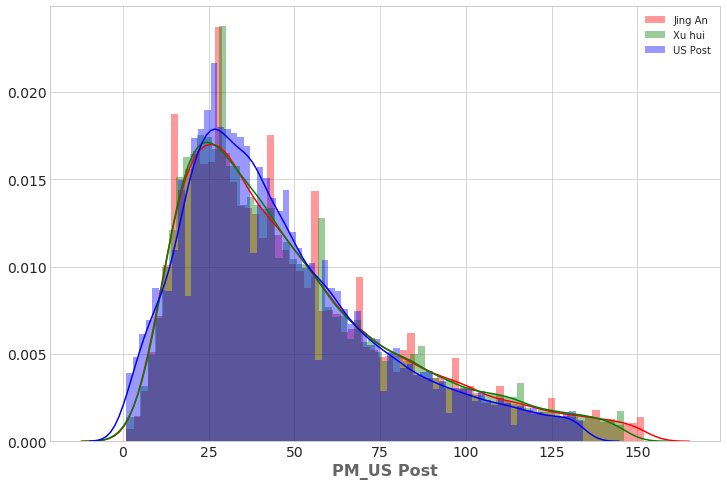

In [152]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(pm['PM_Jingan'].dropna()[~is_outlier(pm['PM_Jingan'].dropna())], color = 'r', label = 'Jing An',bins=70, ax=ax, kde=True)
sns.distplot(pm['PM_Xuhui'].dropna()[~is_outlier(pm['PM_Xuhui'].dropna())], color = 'g', label = 'Xu hui', bins=70, ax=ax, kde=True)
sns.distplot(pm['PM_US Post'].dropna()[~is_outlier(pm['PM_US Post'].dropna())], color = 'b',label = 'US Post',bins=70, ax=ax, kde=True)
plt.legend(loc='upper right')
plt.show()

In [153]:
#convert month/day/hour to format with consistent length
pm["month"] = pm.month.map("{:02}".format)
pm["day"] = pm.day.map("{:02}".format)
pm["hour"] = pm.hour.map("{:02}".format)

In [154]:
for col in ['year', 'month', 'day', 'hour','season', 'cbwd']:
    pm[col] = pm[col].astype('str')

In [155]:
pm.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,01,01,00,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0
1,2,2010,01,01,01,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0
2,3,2010,01,01,02,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0
3,4,2010,01,01,03,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0
4,5,2010,01,01,04,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0


In [156]:
#numeric variables statistics
pm.describe()

,No,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,52584.000000,24700.000000,34039.000000,25189.000000,52571.000000,52571.000000,52556.000000,52571.000000,52572.000000,48575.000000,48575.000000
mean,26292.500000,57.395992,52.910544,57.678987,11.295372,69.545646,1016.017564,17.471115,49.602367,0.142001,0.935362
std,15179.837614,47.616179,42.576138,48.412620,9.877649,17.658942,9.016829,9.315528,78.283572,1.065094,6.586855
min,1.000000,1.000000,1.000000,1.000000,-21.000000,11.320000,990.000000,-5.000000,0.000000,0.000000,0.000000
25%,13146.750000,26.000000,26.000000,26.000000,3.000000,57.930000,1008.100000,10.000000,6.000000,0.000000,0.000000
50%,26292.500000,44.000000,41.000000,43.000000,12.000000,72.420000,1016.000000,18.000000,20.000000,0.000000,0.000000
75%,39438.250000,73.000000,67.000000,73.000000,20.000000,83.370000,1023.000000,25.000000,61.000000,0.000000,0.000000
max,52584.000000,635.000000,730.000000,636.000000,28.000000,100.000000,1040.000000,41.000000,1110.000000,61.600000,226.400000


In [157]:
# Describing all the Categorical Features
pm.describe(include=['O'])

,year,month,day,hour,season,cbwd
count,52584,52584,52584,52584,52584,52584
unique,6,12,31,24,4,6
top,2012,12,17,23,2,NE
freq,8784,4464,1728,2191,13248,19497


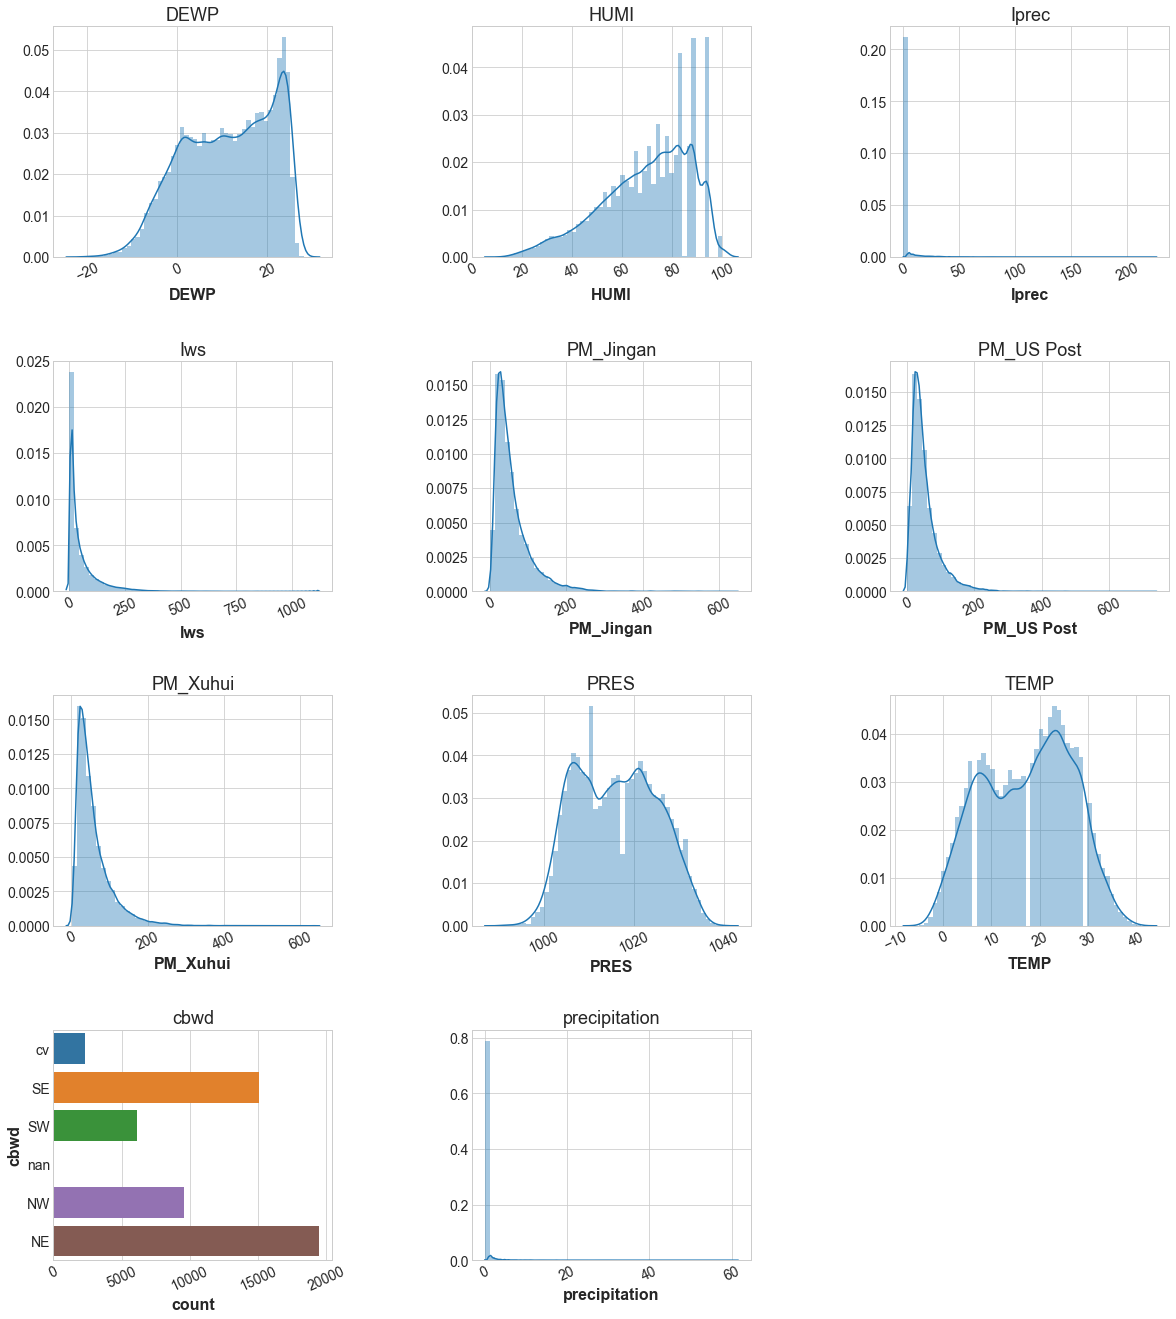

In [158]:
# Let’s plot the distribution of each feature
import math
def plot_distribution(dataset, excl=[], cols=5, width=20, height=35, hspace=0.2, wspace=0.5):
    """print distribution for both categorical and numeric variables
    Parameters
    ----------
    dataset: dataframe - 
    excl: list - list of variables excluded from printing
    width: 
    """
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    if len(excl)!=0:
        columns_remain = sorted(list(set(dataset.columns) - set(excl)))
    for i, column in enumerate(columns_remain):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column, fontsize = 18)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column].dropna(), kde=True, rug=False)
            plt.xticks(rotation=25)
            

#the distribution of three locations' measurements are quite similar (all right skewed)          
plot_distribution(pm, excl=['No','year','season','month','day','hour'], cols=3, width=20, height=35, hspace=0.45, wspace=0.5)


In [159]:
#create complete timestamp
pm['fulltime'] = pm['year'] +"-"+pm['month']+"-"+pm['day']+" "+pm['hour']

In [160]:
from datetime import datetime
pm['fulltime'] = pd.to_datetime(pm['fulltime'])

In [161]:
pm.dtypes

No                        int64
year                     object
month                    object
day                      object
hour                     object
season                   object
PM_Jingan               float64
PM_US Post              float64
PM_Xuhui                float64
DEWP                    float64
HUMI                    float64
PRES                    float64
TEMP                    float64
cbwd                     object
Iws                     float64
precipitation           float64
Iprec                   float64
fulltime         datetime64[ns]
dtype: object

In [162]:
pm.index = pm['fulltime']

In [163]:
pm.index

DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 01:00:00',
               '2010-01-01 02:00:00', '2010-01-01 03:00:00',
               '2010-01-01 04:00:00', '2010-01-01 05:00:00',
               '2010-01-01 06:00:00', '2010-01-01 07:00:00',
               '2010-01-01 08:00:00', '2010-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'fulltime', length=52584, freq=None)

In [164]:
#The day of the week with Monday=0, Sunday=6
pm['weekday'] = pm.index.dayofweek
weekday_dict={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
pm['weekday'] = pm['weekday'].map(weekday_dict)

- Analyze relations among the PM2.5 measurements from three different locations

In [165]:
PM_col=['PM_Jingan', 'PM_US Post', 'PM_Xuhui']
#only keep records where all three locations' measurements are available
pm_all = pm.dropna(subset = PM_col)

In [166]:
pm_all.index = pm_all['fulltime']
pm_all.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,fulltime,weekday
fulltime,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,26305,2013,01,01,00,4,66.0,70.0,71.0,-5.0,69.00,1023.0,0.0,SW,60.0,0.0,0.0,2013-01-01 00:00:00,Tuesday
2013-01-01 01:00:00,26306,2013,01,01,01,4,67.0,76.0,72.0,-5.0,69.00,1023.0,0.0,SW,62.0,0.0,0.0,2013-01-01 01:00:00,Tuesday
2013-01-01 03:00:00,26308,2013,01,01,03,4,73.0,78.0,74.0,-4.0,74.41,1023.0,0.0,SW,65.0,0.0,0.0,2013-01-01 03:00:00,Tuesday
2013-01-01 04:00:00,26309,2013,01,01,04,4,75.0,77.0,77.0,-4.0,80.04,1023.0,-1.0,SW,68.0,0.0,0.0,2013-01-01 04:00:00,Tuesday
2013-01-01 05:00:00,26310,2013,01,01,05,4,73.0,78.0,80.0,-4.0,80.04,1023.0,-1.0,SW,70.0,0.0,0.0,2013-01-01 05:00:00,Tuesday


In [167]:
pm_all.shape

(23291, 19)

In [168]:
import plotly.plotly as py
#import plotly
import plotly.tools as tls
tls.set_config_file(world_readable=True,sharing='public')
tls.set_credentials_file(username='jessegu', api_key='lKp4idQkDi31RYcGQ7VK')

In [169]:
import plotly.graph_objs as go 
jingan_trace = go.Scatter(x=pm_all.index, y=pm_all.PM_Jingan, name = 'Jingan')
us_trace = go.Scatter(x=pm_all.index, y=pm_all['PM_US Post'], name = 'US Post')
xuhui_trace = go.Scatter(x=pm_all.index, y=pm_all.PM_Xuhui, name = 'Xuhui')
data = [jingan_trace, us_trace, xuhui_trace]

In [170]:
#create interactive to facilitate comparisons of the three locations' measurements
'''#layout = dict(
    title='Time series with range slider and selectors',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                 dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=1, label='1y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(), type='date'
    )
)

#fig = dict(data=data, layout=layout)
#py.iplot(fig)
'''

"#layout = dict(\n    title='Time series with range slider and selectors',\n    xaxis=dict(\n        rangeselector=dict(\n            buttons=list([\n                dict(count=1, label='1m', step='month', stepmode='backward'),\n                 dict(count=3, label='3m', step='month', stepmode='backward'),\n                dict(count=6, label='6m', step='month', stepmode='backward'),\n                dict(count=1, label='1y', step='year', stepmode='backward'),\n                dict(step='all')\n            ])\n        ),\n        rangeslider=dict(), type='date'\n    )\n)\n\n#fig = dict(data=data, layout=layout)\n#py.iplot(fig)\n"

In [171]:
#create long format from three locations from pm_all
pm25_loc = pd.melt(pm_all, id_vars=['fulltime'], value_vars=PM_col, var_name='location', value_name='PM25')
pm25_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69873 entries, 0 to 69872
Data columns (total 3 columns):
fulltime    69873 non-null datetime64[ns]
location    69873 non-null object
PM25        69873 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.6+ MB


In [172]:
pm25_loc.head()

,fulltime,location,PM25
0,2013-01-01 00:00:00,PM_Jingan,66.0
1,2013-01-01 01:00:00,PM_Jingan,67.0
2,2013-01-01 03:00:00,PM_Jingan,73.0
3,2013-01-01 04:00:00,PM_Jingan,75.0
4,2013-01-01 05:00:00,PM_Jingan,73.0


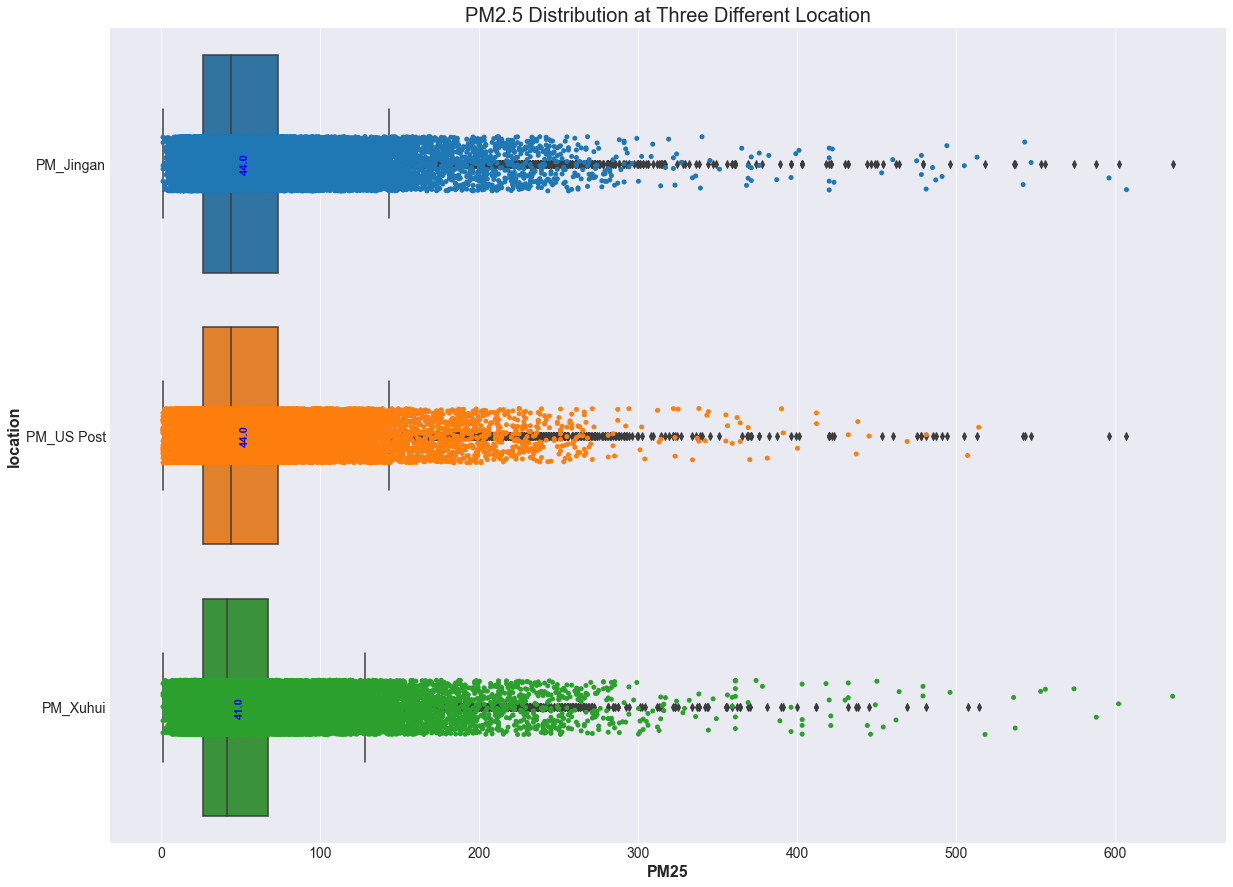

In [173]:
"""sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (20,15)})
ax = sns.boxplot(y="location", x="PM25", data=pm25_loc)
#ax = sns.violinplot(y="location", x="PM25", data=pm25_loc)
ax = sns.stripplot(y="location", x="PM25", data=pm25_loc, jitter = True, edgecolor="gray")
"""
def box_strip(title, cat, val, data, size, vertical = True, ascend = False):
    """print boxplot and stripplot in seeaborn library
    Parameters
    ----------
    cat: column name for category variable used for grouping
    val: column name for numeric variable used by cat
    data: dataset
    size: size (width, height) of the plot
    ascend: whether or not print the plot by the ascending median value of y
    """
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(size[0], size[1]))
    #sns.set_context(rc={"figure.figsize": size})
    #sort median value
    my_order = data.groupby(by=[cat])[val].median().sort_values(ascending = ascend)
    
    if vertical:
        ax = sns.boxplot(y=cat, x=val, data=data, order = my_order.index)
        ax = sns.stripplot(y=cat, x=val, data=data, jitter = True, edgecolor="gray")
    else:
        ax = sns.boxplot(y=val, x=cat, data=data, order = my_order.index)
        ax = sns.stripplot(y=val, x=cat, data=data, jitter = True, edgecolor="gray")
        
    medians = my_order.values
    median_labels = [str(np.round(s, 2)) for s in medians]
    pos = range(len(median_labels))
    
    #print median values
    for tick,label in zip(pos,ax.get_yticklabels()):
        if vertical:
            ax.text(medians[tick] + 5, pos[tick], median_labels[tick], verticalalignment='center', 
                    rotation = 'vertical', size='x-small', color='b', weight='bold',fontsize=14)
        else:
            ax.text(pos[tick], medians[tick] + 5, median_labels[tick], horizontalalignment='center', 
                    rotation = 'horizontal', size='x-small', color='b', weight='bold',fontsize=14)
       
    ax.set_title(title)
    
    
box_strip('PM2.5 Distribution at Three Different Location', 'location', 'PM25',
                   data= pm25_loc, size = (20, 15), vertical = True, ascend = False)

In [174]:
pm_all.loc[:,PM_col].describe()

,PM_Jingan,PM_US Post,PM_Xuhui
count,23291.000000,23291.000000,23291.000000
mean,57.632777,53.535829,58.119231
std,47.415120,42.623180,48.491861
min,1.000000,1.000000,1.000000
25%,26.000000,26.000000,26.000000
50%,44.000000,41.000000,44.000000
75%,73.000000,67.000000,73.000000
max,607.000000,514.000000,636.000000


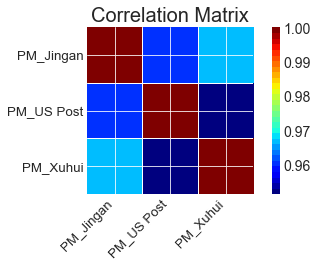

In [175]:
from matplotlib import cm as cm
cmap = cm.get_cmap('jet', 30)
corr_matrix = np.corrcoef(pm_all.loc[:,PM_col].T)
smg.plot_corr(corr_matrix, xnames=pm_all.loc[:,PM_col].columns, cmap=cmap)
plt.show()

In [176]:
pm_all.loc[:,PM_col].corr()

,PM_Jingan,PM_US Post,PM_Xuhui
PM_Jingan,1.000000,0.960646,0.966114
PM_US Post,0.960646,1.000000,0.951497
PM_Xuhui,0.966114,0.951497,1.000000


### Create One final dependent variable
Since PM2.5 values are highly correlated, we will use the mean value of the measurements from three locations

In [177]:
#new PM25 data (dependent variable) that is the mean of three locations' measurements
pm['Avg_PM'] = pm[PM_col].mean(axis = 1)

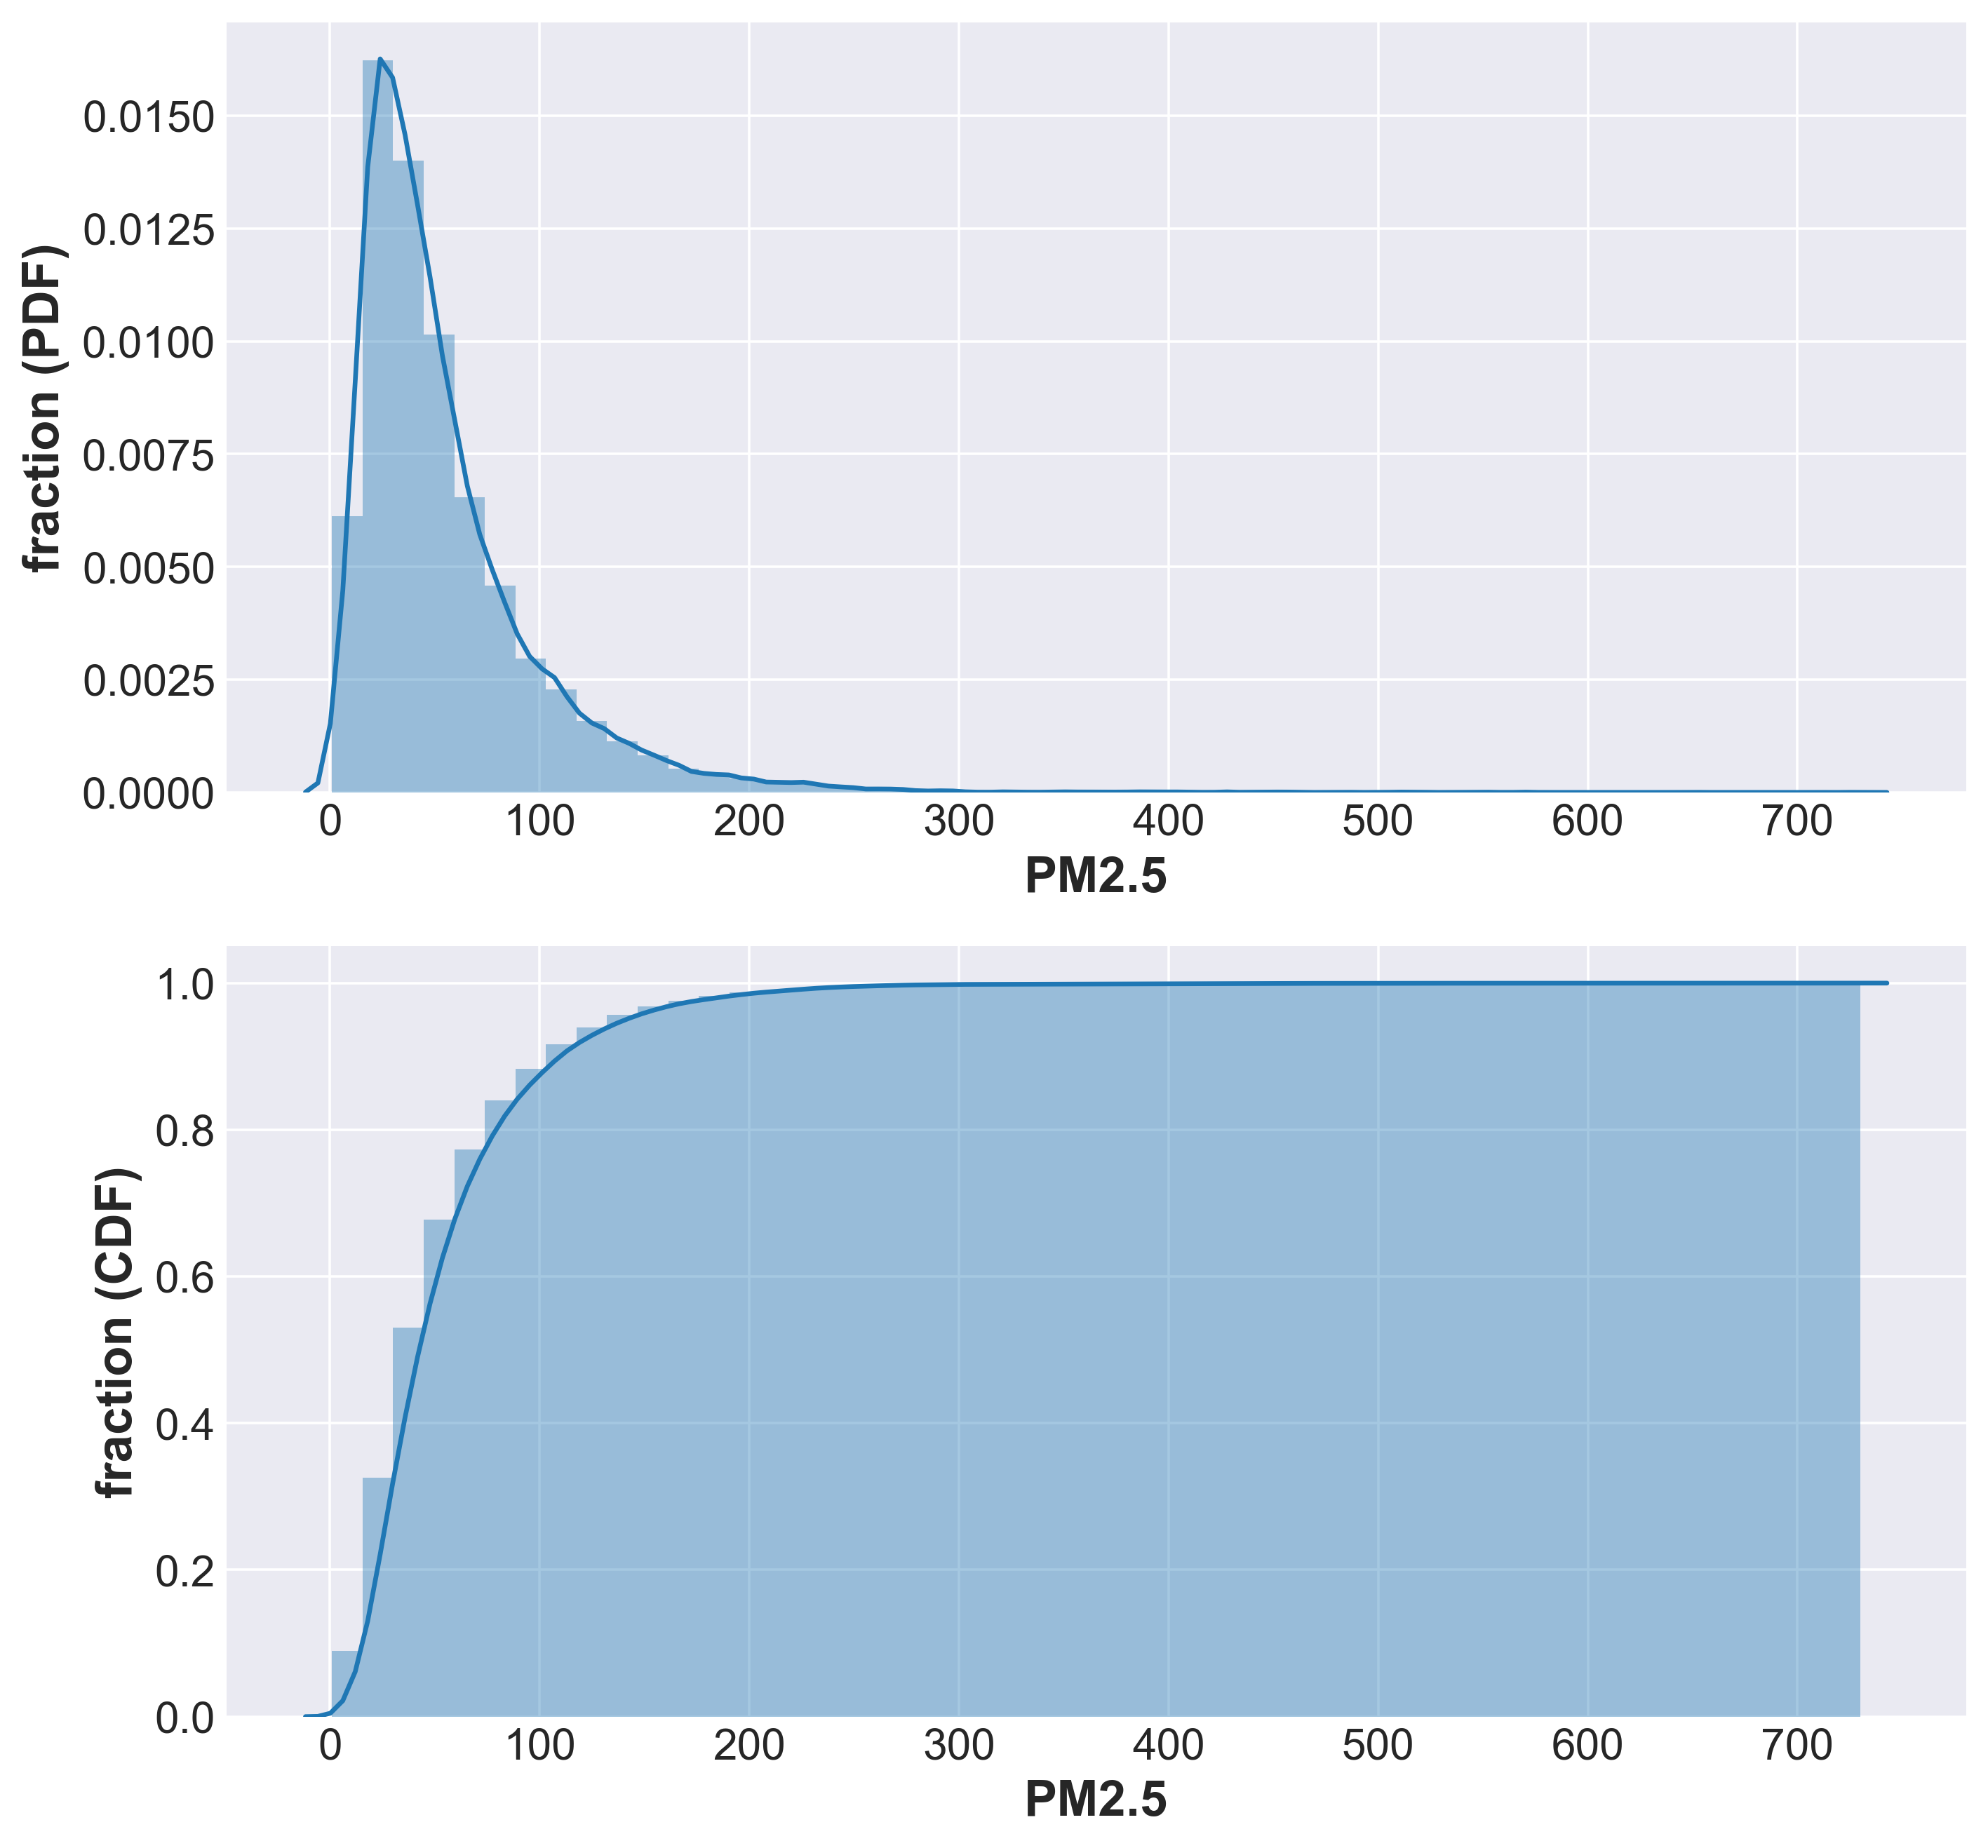

In [178]:
# settings
f, axes = plt.subplots(2, 1, figsize=(10,10), dpi=320)
axes[0].set_ylabel('fraction (PDF)')
axes[1].set_ylabel('fraction (CDF)')

# left plot (PDF) 
sns.distplot(
    pm['Avg_PM'].dropna(), kde=True, axlabel='PM2.5',
    ax=axes[0]
)

# right plot (CDF)
sns.distplot(
    pm['Avg_PM'].dropna(), kde=True, axlabel='PM2.5',
    hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, ax=axes[1],
)

In [179]:
print ('Mean of PM2.5 is:'+ str(pm['Avg_PM'].mean()))
print ('Median of PM2.5 is:'+ str(pm['Avg_PM'].median()))
print ('Standard Deviation of PM2.5 is:'+ str(pm['Avg_PM'].std()))
print ('------------------------------------')

#Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. 
#The skewness value can be positive or negative, or undefined. ---- "Positive skew"
print ('Skewness of PM2.5 is:'+ str(pm['Avg_PM'].skew()))

#Kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable. The kurtosis is 
#the fourth standardized moment. kurtosis measures outliers only; it measures nothing about the "peak."
#High values of Kurtosis arise in two circumstances:
#where the probability mass is concentrated around the mean and the data-generating process produces occasional values far from the mean,
#where the probability mass is concentrated in the tails of the distribution.
#positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates a "light tailed" distribution.
#----"heavy-tailed"
print ('Kurt of PM2.5 is:'+ str(pm['Avg_PM'].kurt()))

Mean of PM2.5 is:54.8388657374
Median of PM2.5 is:42.3333333333
Standard Deviation of PM2.5 is:44.5804771631
------------------------------------
Skewness of PM2.5 is:2.60197949587
Kurt of PM2.5 is:13.6598842858


In [180]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 20 columns):
No               52584 non-null int64
year             52584 non-null object
month            52584 non-null object
day              52584 non-null object
hour             52584 non-null object
season           52584 non-null object
PM_Jingan        24700 non-null float64
PM_US Post       34039 non-null float64
PM_Xuhui         25189 non-null float64
DEWP             52571 non-null float64
HUMI             52571 non-null float64
PRES             52556 non-null float64
TEMP             52571 non-null float64
cbwd             52584 non-null object
Iws              52572 non-null float64
precipitation    48575 non-null float64
Iprec            48575 non-null float64
fulltime         52584 non-null datetime64[ns]
weekday          52584 non-null object
Avg_PM           34795 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1), object(7

In [181]:
pm.head()

,No,year,month,day,hour,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,fulltime,weekday,Avg_PM
fulltime,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,01,01,00,4,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,0.0,0.0,2010-01-01 00:00:00,Friday,NaN
2010-01-01 01:00:00,2,2010,01,01,01,4,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,0.0,0.0,2010-01-01 01:00:00,Friday,NaN
2010-01-01 02:00:00,3,2010,01,01,02,4,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,0.0,0.0,2010-01-01 02:00:00,Friday,NaN
2010-01-01 03:00:00,4,2010,01,01,03,4,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,0.0,0.0,2010-01-01 03:00:00,Friday,NaN
2010-01-01 04:00:00,5,2010,01,01,04,4,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,0.0,0.0,2010-01-01 04:00:00,Friday,NaN


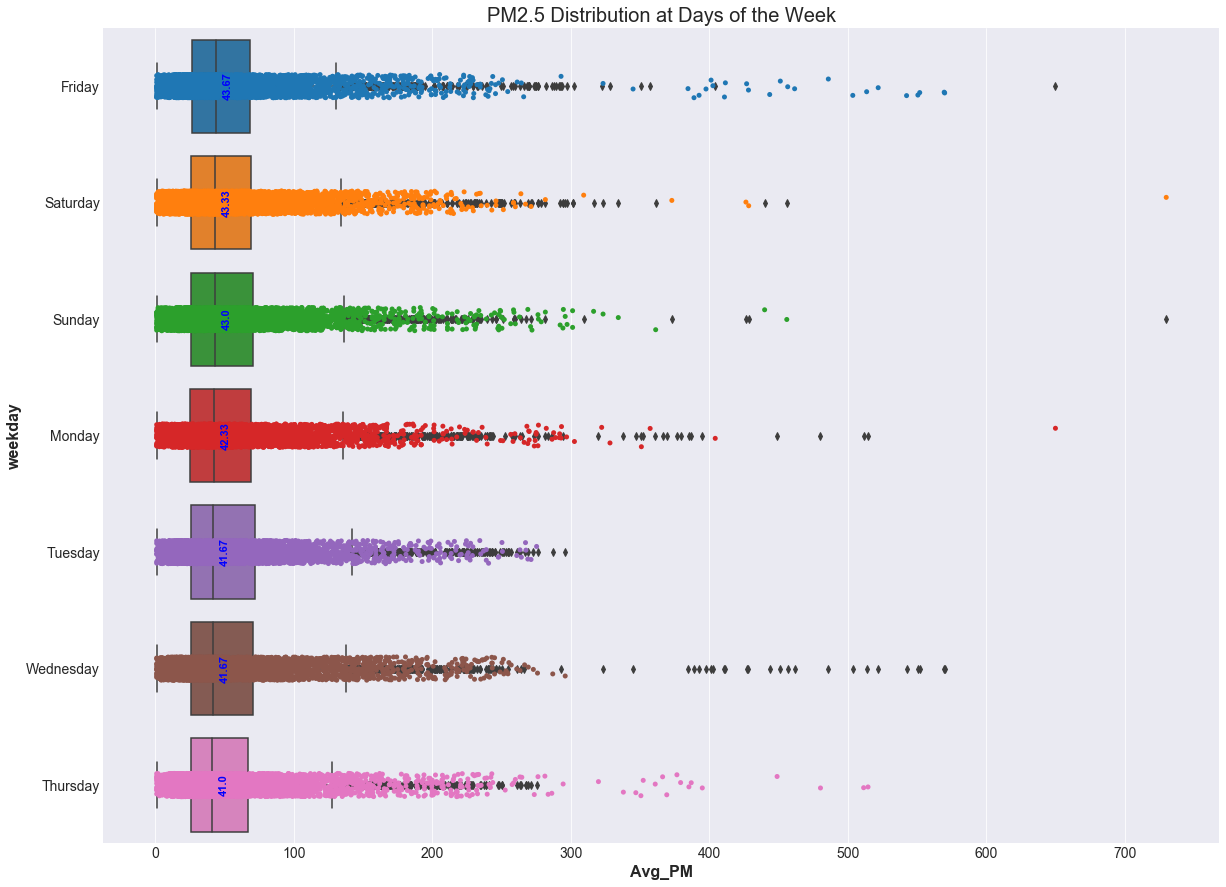

In [182]:
box_strip('PM2.5 Distribution at Days of the Week', 'weekday', 'Avg_PM', data= pm, 
          size = (20, 15), vertical = True, ascend = False)

In [183]:
pm['cbwd'].value_counts()

NE     19497
SE     15073
NW      9569
SW      6108
cv      2325
nan       12
Name: cbwd, dtype: int64

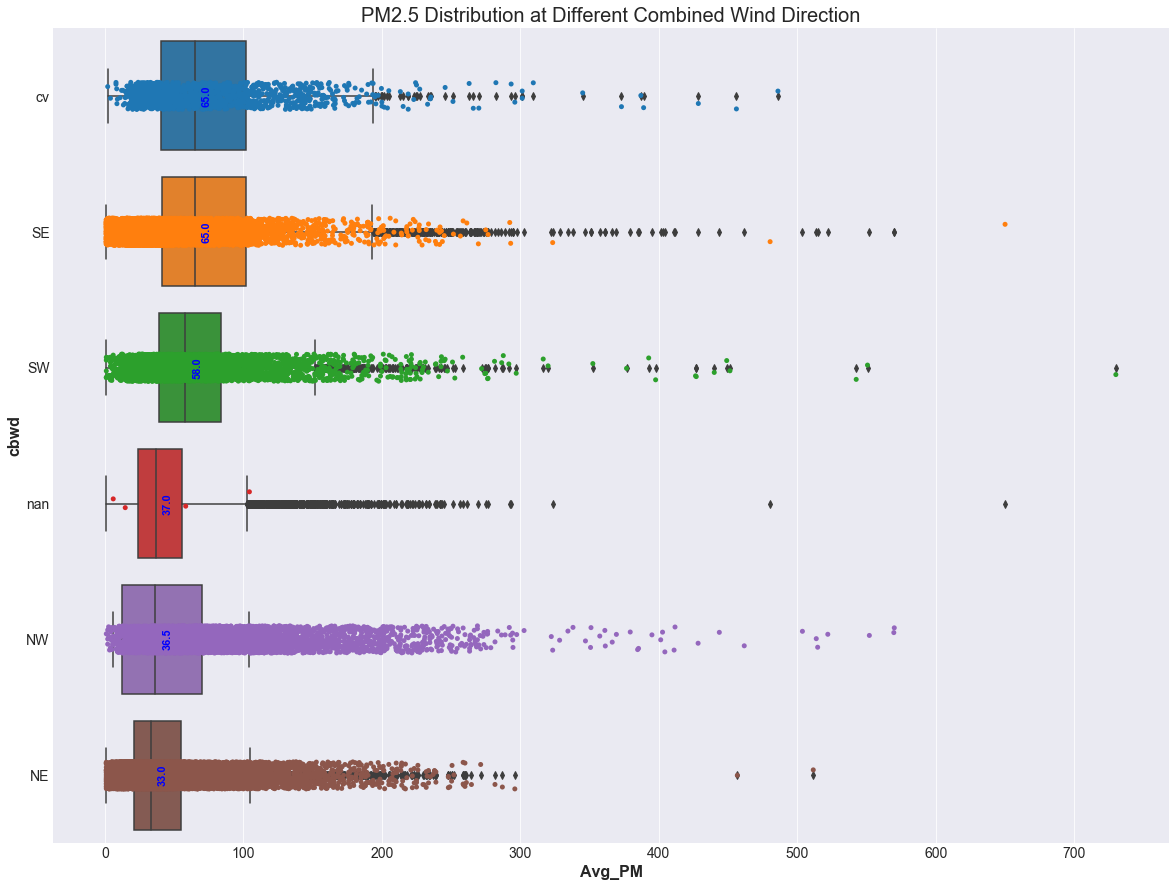

In [184]:
box_strip('PM2.5 Distribution at Different Combined Wind Direction', 'cbwd', 'Avg_PM',
                   data= pm, size = (20, 15), vertical = True, ascend = False)

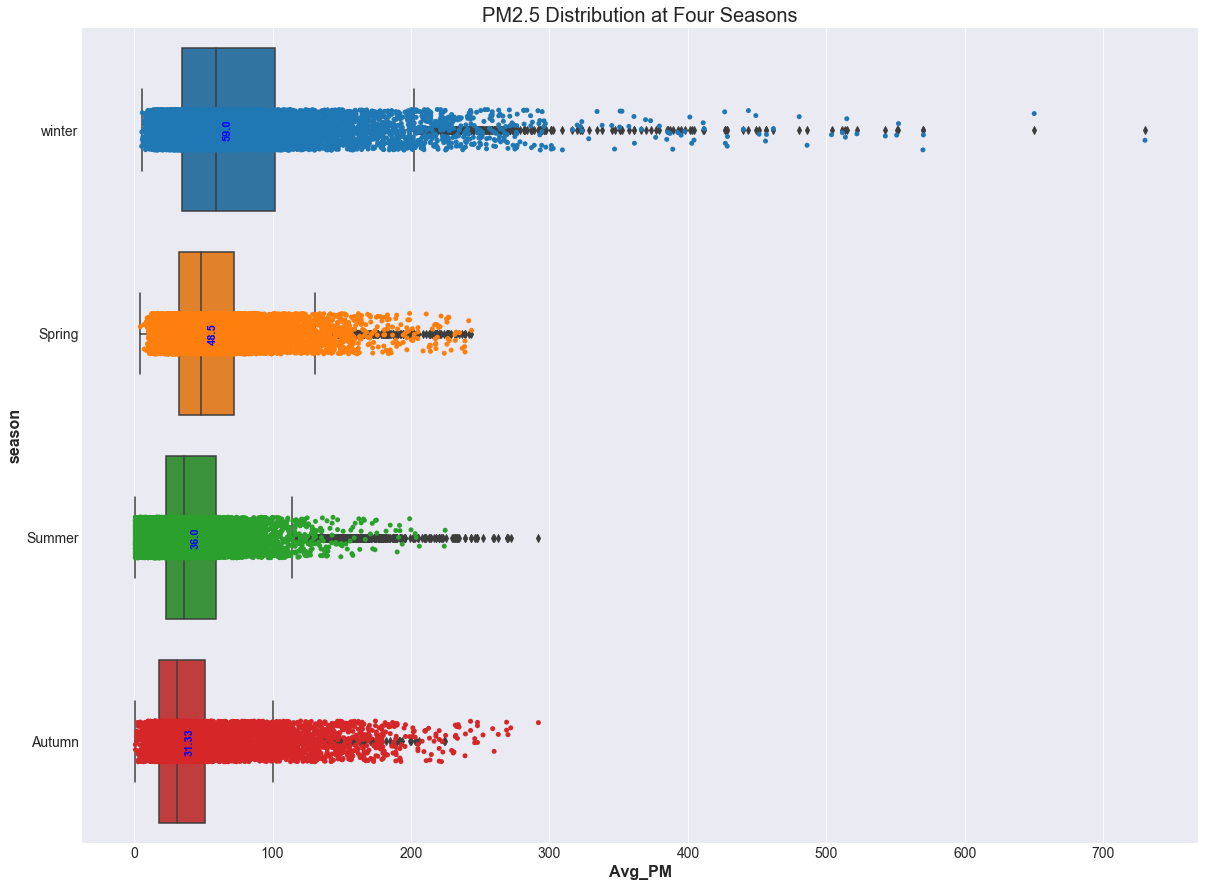

In [185]:
season = {'1':'Spring','2':'Summer','3':'Autumn','4':'winter'}
pm['season'] = [season[x] for x in pm['season']]

box_strip('PM2.5 Distribution at Four Seasons', 'season','Avg_PM', 
                   data= pm, size = (20, 15), vertical = True, ascend = False)


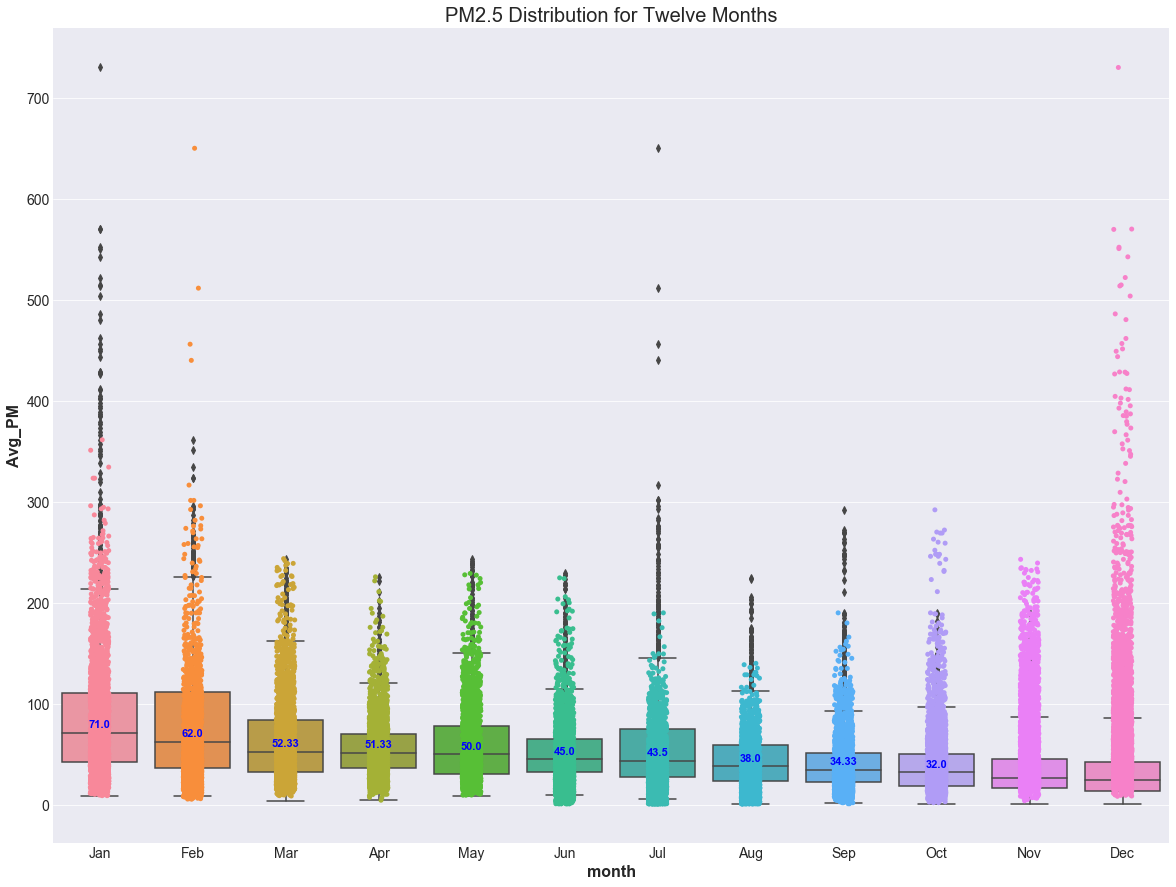

In [186]:
month_map = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct',
             '11':'Nov','12':'Dec'}
pm['month'] = [month_map[x] for x in pm['month']]

box_strip('PM2.5 Distribution for Twelve Months', 'month','Avg_PM', 
                   data= pm, size = (20, 15), vertical = False, ascend = False)